In [10]:
# --- Imports essentiels : chargement des bibliothèques pour calcul et visualisation ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cpu


## 1. Encodeur de Caractères Simple

In [11]:
# --- Définition d'un encodeur caractère -> indice
class SimpleEncoder:
    def __init__(self):
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0
    
    def fit(self, text):
        chars = sorted(list(set(text)))
        self.vocab_size = len(chars)
        self.char_to_idx = {char: i for i, char in enumerate(chars)}
        self.idx_to_char = {i: char for i, char in enumerate(chars)}
    
    def encode(self, text):
        return [self.char_to_idx.get(char, 0) for char in text]

# Test de l'encodeur
sample_text = "Bonjour le monde! Les roses sont belles."
encoder = SimpleEncoder()
encoder.fit(sample_text)
print(f"Vocabulaire: {len(encoder.char_to_idx)} caractères")
print(f"Exemple: '{sample_text[:10]}' -> {encoder.encode(sample_text[:10])}")

Vocabulaire: 17 caractères
Exemple: 'Bonjour le' -> [3, 12, 11, 8, 12, 16, 13, 0, 9, 7]


## 2. Génération de Poèmes

In [12]:
# ---------------------------------------------------------------------------
#                       Section Génération de Poèmes                         
# ---------------------------------------------------------------------------
# Charger le corpus de poésie depuis le fichier
with open('data/poetry_corpus.txt', 'r', encoding='utf-8') as f:
    poetry_corpus = f.read()

# Modèle LSTM minimaliste pour prédire le prochain caractère
class PoetryLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PoetryLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
    
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded, hidden)
        output = self.fc(output)
        return output, hidden

def create_sequences(text, char_to_idx, seq_length=15):
    indices = [char_to_idx.get(char, 0) for char in text]
    sequences, targets = [], []
    
    for i in range(len(indices) - seq_length):
        sequences.append(indices[i:i + seq_length])
        targets.append(indices[i + 1:i + seq_length + 1])
    
    return torch.tensor(sequences), torch.tensor(targets)

# Encodage du texte sous forme de séquences d'indices et création des cibles
# Préparer les données
poetry_encoder = SimpleEncoder()
poetry_encoder.fit(poetry_corpus)
X_poetry, y_poetry = create_sequences(poetry_corpus, poetry_encoder.char_to_idx)

print(f"Corpus chargé: {len(poetry_corpus)} caractères")
print(f"Vocabulaire poésie: {poetry_encoder.vocab_size} caractères")
print(f"Séquences d'entraînement: {X_poetry.shape[0]}")

Corpus chargé: 3525 caractères
Vocabulaire poésie: 63 caractères
Séquences d'entraînement: 3510


### Entraînement du modèle de poésie

Entraînement du modèle de poésie...
Epoch 20, Loss: 1.9878
Epoch 40, Loss: 1.4531
Epoch 60, Loss: 1.0581
Epoch 80, Loss: 0.7816


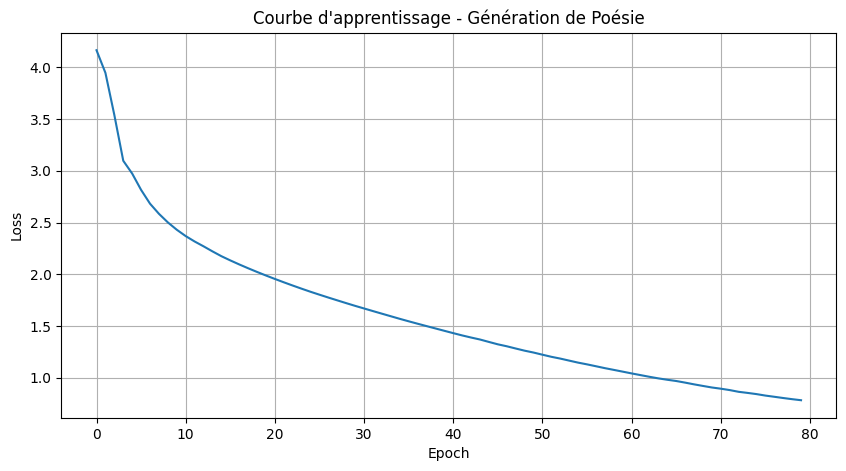

In [ ]:
# Créer et entraîner le modèle de poésie
poetry_model = PoetryLSTM(poetry_encoder.vocab_size, 64, 128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(poetry_model.parameters(), lr=0.01)

# ---------------------------------------------------------------
#  Boucle d'entraînement : propagation avant, calcul de perte,   
#  rétro-propagation et mise à jour des poids                    
# ---------------------------------------------------------------
def train_poetry_model(model, X, y, epochs=100 ):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        output, _ = model(X)
        loss = criterion(output.view(-1, poetry_encoder.vocab_size), y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return losses

print("Entraînement du modèle de poésie...")
poetry_losses = train_poetry_model(poetry_model, X_poetry, y_poetry, epochs=80)

# Graphique des pertes
plt.figure(figsize=(10, 5))
plt.plot(poetry_losses)
plt.title('Courbe d\'apprentissage - Génération de Poésie')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Génération de nouveaux poèmes

In [14]:
def generate_poetry(model, encoder, seed="Les", length=100, temperature=0.8):
    model.eval()
    with torch.no_grad():
        chars = [encoder.char_to_idx.get(c, 0) for c in seed]
        generated = seed
        
        for _ in range(length):
            input_seq = torch.tensor([chars[-15:]]).long()  # Derniers 15 caractères
            output, _ = model(input_seq)
            
            # Appliquer la température
            probs = F.softmax(output[0, -1] / temperature, dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = encoder.idx_to_char.get(next_char_idx, '')
            
            generated += next_char
            chars.append(next_char_idx)
            
            # Arrêter à la fin d'une strophe
            if '.\n' in generated[-3:] and len(generated) > 50:
                break
    
    return generated

# Générer des poèmes
print("Génération de nouveaux poèmes :")
print("=" * 50)

seeds = ["Les", "Dans", "L'amour", "La"]
for i, seed in enumerate(seeds, 1):
    poem = generate_poetry(poetry_model, poetry_encoder, seed, length=80)
    print(f"\nPoème {i} (seed: '{seed}'):")
    print(poem.strip())
    print("-" * 30)

Génération de nouveaux poèmes :

Poème 1 (seed: 'Les'):
Les rivière, dansé.
Les secrets,
De notoilée des secrets,
De nose,
Qui baise,
Qui r
------------------------------

Poème 2 (seed: 'Dans'):
Dans le bruissement et lon émotoique cieux comme des violons de les poèmes nous ruse
------------------------------

Poème 3 (seed: 'L'amour'):
L'amour ets,
De nos et silecrent les pure,
Et les rêveurs,
Vers qui seauté,
Vers des ré
------------------------------

Poème 4 (seed: 'La'):
La des madins,
Dans le sinence,
Où l'espoir es res anciens,
De leurs marchent les
------------------------------


## 3. Analyse de Sentiments

In [15]:
# Charger et préparer les données de sentiment depuis le fichier
def load_sentiment_data(file_path):
    texts, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    texts.append(parts[0])
                    labels.append(int(parts[1]))
    return texts, labels

# Charger les données
texts, labels = load_sentiment_data('data/sentiment_data.txt')

# Créer l'encodeur pour les sentiments
sentiment_encoder = SimpleEncoder()
all_text = ' '.join(texts)
sentiment_encoder.fit(all_text)

print(f"Données chargées: {len(texts)} exemples")
print(f"Vocabulaire sentiment: {sentiment_encoder.vocab_size} caractères")
print(f"Répartition: {sum(labels)} positifs, {len(labels) - sum(labels)} négatifs")

Données chargées: 90 exemples
Vocabulaire sentiment: 35 caractères
Répartition: 50 positifs, 40 négatifs


In [16]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # 2 classes : positif/négatif
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        output = self.dropout(hidden[-1])  # Utiliser le dernier état caché
        output = self.fc(output)
        return output

def prepare_sentiment_data(texts, labels, encoder, max_len=30):
    sequences = []
    for text in texts:
        indices = [encoder.char_to_idx.get(char, 0) for char in text[:max_len]]
        # Padding
        if len(indices) < max_len:
            indices.extend([0] * (max_len - len(indices)))
        sequences.append(indices)
    
    return torch.tensor(sequences), torch.tensor(labels)

# Préparer les données
X_sentiment, y_sentiment = prepare_sentiment_data(texts, labels, sentiment_encoder)

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_sentiment, y_sentiment, test_size=0.3, random_state=42
)

print(f"Train: {X_train.shape[0]} exemples")
print(f"Test: {X_test.shape[0]} exemples")

Train: 63 exemples
Test: 27 exemples


Entraînement du modèle de sentiment...
Epoch 20, Loss: 0.0856, Test Acc: 0.5926
Epoch 40, Loss: 0.0765, Test Acc: 0.4815
Epoch 60, Loss: 0.0934, Test Acc: 0.4815
Epoch 80, Loss: 0.0773, Test Acc: 0.5185
Epoch 100, Loss: 0.0761, Test Acc: 0.5556


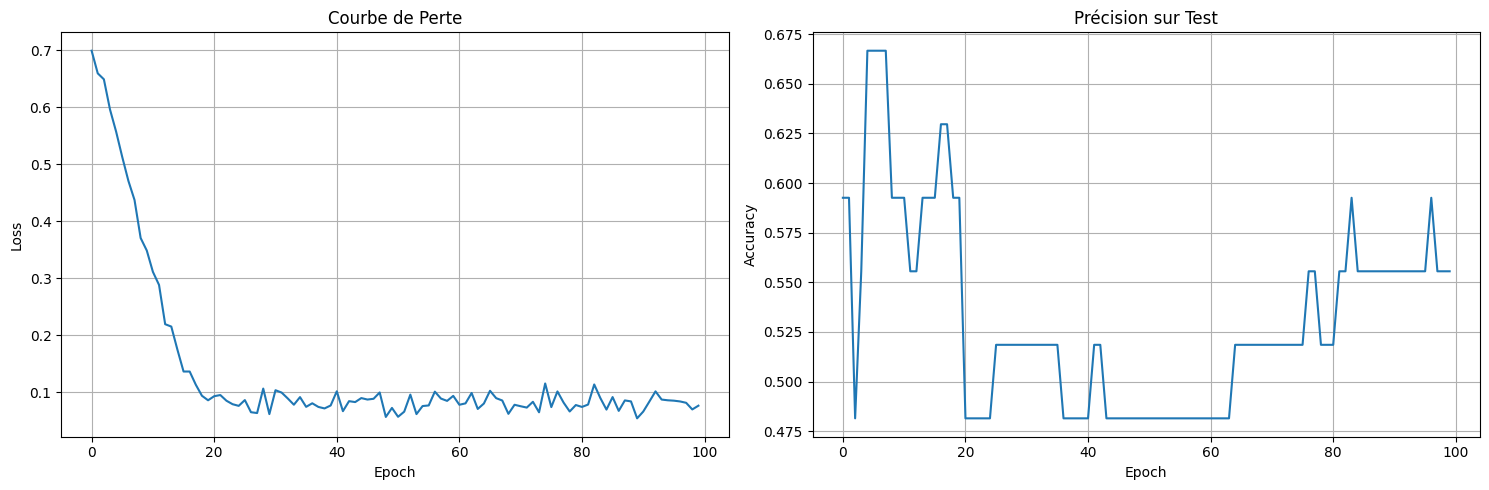

Précision finale: 0.5556


In [17]:
# Créer et entraîner le modèle de sentiment
sentiment_model = SentimentLSTM(sentiment_encoder.vocab_size, 32, 64)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sentiment_model.parameters(), lr=0.01)

def train_sentiment_model(model, X_train, y_train, X_test, y_test, epochs=100):
    train_losses, test_accuracies = [], []
    
    for epoch in range(epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Évaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            predicted = torch.argmax(test_outputs, dim=1)
            accuracy = (predicted == y_test).float().mean().item()
            test_accuracies.append(accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Test Acc: {accuracy:.4f}')
    
    return train_losses, test_accuracies

print("Entraînement du modèle de sentiment...")
losses, accuracies = train_sentiment_model(
    sentiment_model, X_train, y_train, X_test, y_test, epochs=100
)

# Graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(losses)
ax1.set_title('Courbe de Perte')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(accuracies)
ax2.set_title('Précision sur Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Précision finale: {accuracies[-1]:.4f}")

### Test du modèle de sentiment

In [18]:
def predict_sentiment(model, encoder, text, max_len=30):
    model.eval()
    with torch.no_grad():
        indices = [encoder.char_to_idx.get(char, 0) for char in text[:max_len]]
        if len(indices) < max_len:
            indices.extend([0] * (max_len - len(indices)))
        
        input_tensor = torch.tensor([indices])
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = probabilities[0, predicted_class].item()
        
        sentiment = "Positif" if predicted_class == 1 else "Négatif"
        return sentiment, confidence

# Tester sur de nouveaux exemples
test_sentences = [
    "J'adore ce nouveau livre",
    "Cette journée est horrible",
    "Je me sens bien aujourd'hui",
    "C'est une catastrophe",
    "Quelle merveilleuse surprise",
    "Je suis déçu",
    "Le soleil brille et tout va bien",
    "Cette situation me rend anxieux"
]

print("Test du classifieur de sentiment :")
print("=" * 50)

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentiment_model, sentiment_encoder, sentence)
    print(f"'{sentence}' -> {sentiment} ({confidence:.3f})")
    print("-" * 40)

Test du classifieur de sentiment :
'J'adore ce nouveau livre' -> Négatif (1.000)
----------------------------------------
'Cette journée est horrible' -> Négatif (1.000)
----------------------------------------
'Je me sens bien aujourd'hui' -> Négatif (0.997)
----------------------------------------
'C'est une catastrophe' -> Négatif (0.997)
----------------------------------------
'Quelle merveilleuse surprise' -> Positif (0.981)
----------------------------------------
'Je suis déçu' -> Négatif (1.000)
----------------------------------------
'Le soleil brille et tout va bien' -> Négatif (0.999)
----------------------------------------
'Cette situation me rend anxieux' -> Négatif (0.990)
----------------------------------------
